In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

import scipy.interpolate as inter
from scipy.signal import butter, sosfreqz, sosfilt


In [2]:
from scipy import fft

def periodogram(x, N_FFT):
    w = fft.fftshift(fft.fftfreq(N_FFT, d=1.0)) * 2 * np.pi
    periodogram = np.abs(fft.fftshift(fft.fft(x, n = N_FFT)))**(2) / len(x) 
    return periodogram, w 


In [3]:
def biased_autocorr(x): 
    corr = np.correlate(x, x, mode = 'full')
    rxx_biased = corr / len(x)
    return rxx_biased

def biased_xcorr(x, y):
    xcorr = np.correlate(x, y, mode = 'full')
    rxy_biased = xcorr / len(x)
    return rxy_biased

def unbiased_autocorr(x):
    corr = np.correlate(x, x, mode = 'full')
    rxx_unbiased = np.array([corr[n] / (len(x) - np.abs(len(x) - 1 - n)) for n in range(0, len(corr))])
    return rxx_unbiased

In [10]:
# x: datos de tamaño N
# L: Siendo (L-1) tamaño del lag máximo de autocorrelación i.e. Rxx(l > |L-1|) = 0
# N_FFT: La cantidad de puntos que se usa en la FFT para visualizar el periodograma. Notar que en clase solemos hacerlo con N, pero podemos
# usar un valor mas chico a N para no hacerlo tan pesado al plot, aunque siempre debe ser mas grande que 2L-1 claramente. 
# Elegir N_FFT != N no "cambia" nada, simplemente se interpola con menos puntos
def periodogram_smoothing(x, L, N_FFT):   

    N = len(x)
    rxx = biased_autocorr(x) # 2N - 1 de largo
    offset = N - 1 
    rxx = rxx[offset - (L-1) : offset + (L-1) + 1] # autocorr ventaneada o windowed con L
    window = signal.get_window(window="parzen", Nx=2*L-1, fftbins= False) 
    rxx_windowed = rxx*window

    Rxx = np.abs(fft.fftshift(fft.fft(rxx_windowed, n = N_FFT))) # (*) ver MARKDOWN ABAJO
    w = fft.fftshift(fft.fftfreq(N_FFT, d=1.0)) * 2 * np.pi

    return Rxx, w

In [5]:
def periodogram_averaging(x, L, D, N_FFT): # procurar que N_FFT > 2L-1
    N = len(x)
    num_segmentos = (N - L)//D      # Cantidad de segmentos con largo L
    Rx = np.zeros(N_FFT)
    for i in range(0, num_segmentos):
        x_seg = x[i*D : i*D + L]
        Rx += 1/L * np.abs(fft.fftshift(fft.fft(x_seg, N_FFT)))**2

    Rx = Rx/num_segmentos
    w = fft.fftshift(fft.fftfreq(N_FFT, d=1.0)) * 2 * np.pi
    return Rx, w

In [6]:
import h5py

def dump_info(name, obj):
    #print("{0} :".format(name))
    try:
        #print("   .value: {0}".format(obj[()]))
        for key in obj.attrs.keys():
            pass
            #print("     .attrs[{0}]:  {1}".format(key, obj.attrs[key]))
    except:
        pass

filename = 'H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5'
file = h5py.File(filename, 'r')
file.visititems(dump_info)

In [7]:
dset = file['strain/Strain'][()]
fs = 1 / file['strain/Strain'].attrs['Xspacing']
print(fs)

4096.0


In [8]:
filename = 'H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'
file_4096 = h5py.File(filename, 'r')
file_4096.visititems(dump_info)
dset_4096 = file['strain/Strain'][()]

In [9]:
#%matplotlib ipympl

Segundos de L =  4.0
Segundos de N =  16.0
Size N =  65536


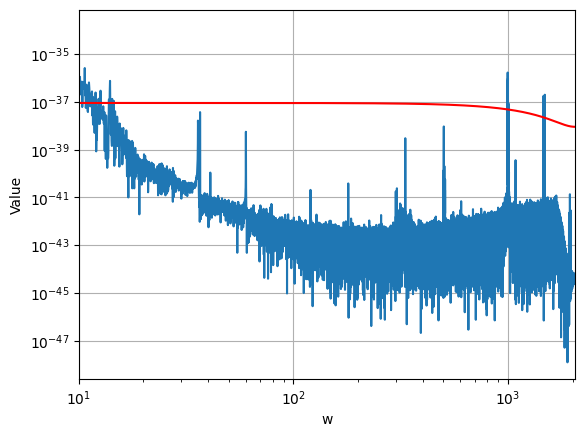

In [9]:

noise1 = dset[:int(14*fs)]

L_seg = 4
L = int(L_seg*fs)
print('Segundos de L = ', L/fs)
N = L*4
print('Segundos de N = ', N/fs)
print('Size N = ', N)

plt.close()
plt.figure()
noisea = noise1[0:N]
Rxx, w = periodogram(dset, 100000)
plt.cla()
w = w * fs / (2*np.pi)
plt.plot(w, Rxx)
Rxx2, w2 = periodogram_smoothing(dset[int(14*fs):], 1, 100000)
w2 = w2 * fs / (2*np.pi)
plt.plot(w2, Rxx2, color = 'r')
#Rxx2, w2 = periodogram(dset, 100000)
#plt.plot(w2, Rxx2, color = 'red')
#pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)*fs/(2*np.pi)
#pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
#plt.xticks(pi_ticks, pi_labels)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('w')
plt.ylabel('Value')
plt.xlim(10, fs/2)
plt.grid(True)
plt.show()

Segundos de L =  5.0
Numero de samples de L =  20480
Segundos de N =  15.0
Size N =  61440
Resolucion Espectral en Hz 0.4


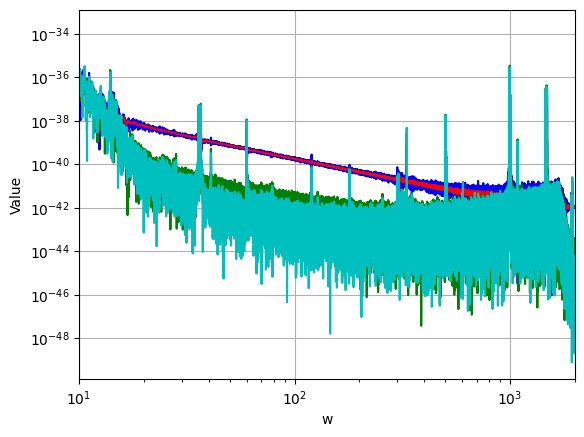

In [11]:
noise1 = dset[:int(14*fs)]

L_seg = 5
L = int(L_seg*fs)
print('Segundos de L = ', L/fs)
print('Numero de samples de L = ', L)
N = int(fs*L_seg*3)
print('Segundos de N = ', N/fs)
print('Size N = ', N)
print('Resolucion Espectral en Hz', 2/L_seg)
noisea = noise1[0:N]
plt.figure()
try:
    Rxx, w = periodogram_smoothing(noisea, L, N)
except CustomException as e:
    print("Custom exception caught:", e)
w = w * fs / (2*np.pi)

Rxx2, w2 = periodogram(noisea, 100000)
w2 = w2 * fs / (2*np.pi)

data = dset[int(0*fs):int(29*fs)]
Rxx3, w3 = periodogram(data, len(data)*2)
w3 = w3 * fs / (2*np.pi)
plt.cla()
plt.xscale('log')
plt.yscale('log')
plt.plot(w2, Rxx2, color = 'b')
plt.plot(w, Rxx, color = 'r')
data = dset
Rxx4, w4 = periodogram(data, len(data)*2)
w4 = w4 * fs / (2*np.pi)
plt.plot(w4, Rxx4, color = 'g')
plt.plot(w3, Rxx3, color = 'c')

#pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)*fs/(2*np.pi)
#pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
#plt.xticks(pi_ticks, pi_labels)
plt.xlabel('w')
plt.ylabel('Value')
plt.xlim(10, 2000)
#plt.ylim(-850, -750)
#plt.xlim(0, np.pi)
plt.grid(True)
plt.show()

In [12]:
data = dset_4096[int(300*fs):int(900*fs)]
Rxx5, w5 = periodogram(data, len(data))
w5 = w5 * fs / (2*np.pi)

plt.figure()
plt.plot(w5, Rxx5, color = 'g')
plt.plot(w4, Rxx4, color = 'r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('w')
plt.ylabel('Value')
plt.xlim(10, 2000)
#plt.ylim(-850, -750)
#plt.xlim(0, np.pi)
plt.grid(True)
plt.show()

ZeroDivisionError: float division by zero

Segundos de L =  3.5
Numero de samples de L =  14336
Resolucion Espectral en Hz 0.5714285714285714


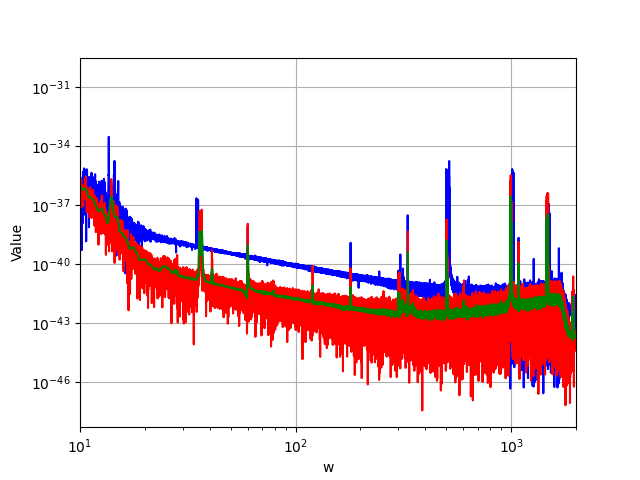

In [ ]:
L_seg = 3.5
L = int(L_seg*fs)
print('Segundos de L = ', L/fs)
print('Numero de samples de L = ', L)
""" N = int(fs*L_seg*3)
print('Segundos de N = ', N/fs)
print('Size N = ', N) """
print('Resolucion Espectral en Hz', 2/L_seg)

data = dset[0:int(32*fs)]
try:
    Rxx, w = periodogram_smoothing(data, L, len(data))
except CustomException as e:
    print("Custom exception caught:", e)

w = w * fs / (2*np.pi)
plt.figure()
plt.plot(w2, Rxx2, color = 'b')
plt.plot(w4, Rxx4, color = 'r')
plt.plot(w, Rxx, color = 'g')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('w')
plt.ylabel('Value')
plt.xlim(10, 2000)
#plt.ylim(-850, -750)
#plt.xlim(0, np.pi)
plt.grid(True)
plt.show()

In [ ]:
%matplotlib ipympl

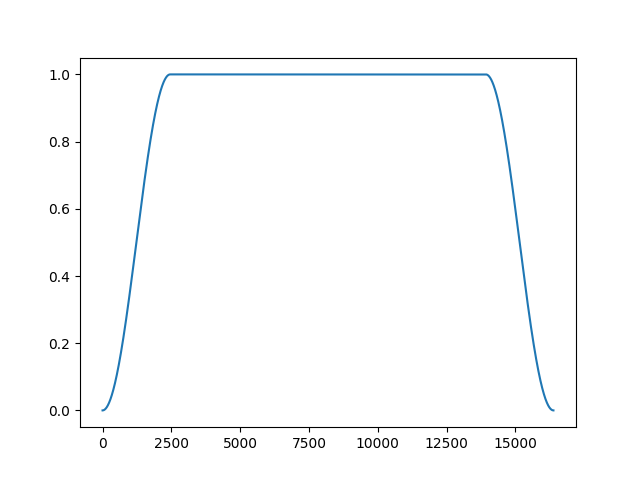

In [ ]:
plt.close()
plt.figure()
plt.plot(tukey(int(4*fs), alpha =  0.3))
plt.show()

STD: =  nan


c:\Users\sch_b\OneDrive\Documentos\PASA\.PASA\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\sch_b\OneDrive\Documentos\PASA\.PASA\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\sch_b\OneDrive\Documentos\PASA\.PASA\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\sch_b\OneDrive\Documentos\PASA\.PASA\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\sch_b\OneDrive\Documentos\PASA\.PASA\Lib\site-packages\IPython\lib\display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


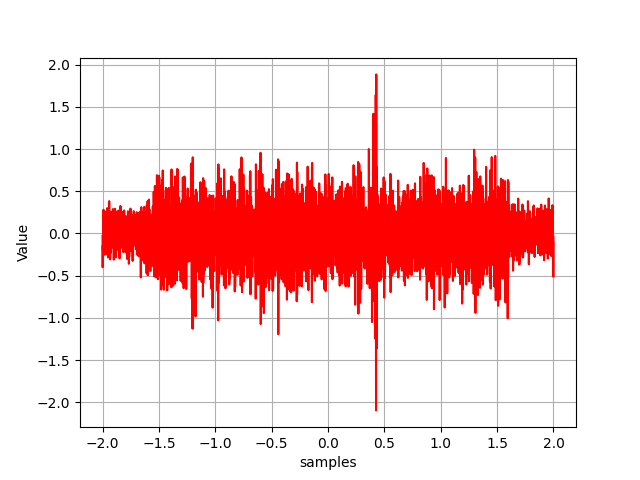

In [ ]:
from IPython.display import Audio
from scipy.signal.windows import tukey

event_time = 1126259462
deltaT = 2
start_time = file['quality/injections/Injmask'].attrs['Xstart']
te = int((event_time-start_time)*fs)
event_samples = dset[te-int(deltaT*fs):te+int(deltaT*fs)] #* signal.get_window(window="hann", Nx=len(event_samples), fftbins= False) 
Nt = len(event_samples) # len(w)

window_tuk = tukey(int(4*fs), alpha =  0.3)
freqs = fft.fftshift(fft.fftfreq(Nt, 1))

hf = fft.fftshift(fft.fft(event_samples * window_tuk, n = Nt))
norm = 1./np.sqrt(1./(1*2))
interpoler = inter.interp1d(w/fs, Rxx)
white_hf = hf / np.sqrt(interpoler(freqs)) * norm
white_ht = fft.ifft(fft.ifftshift(white_hf), n=Nt)  

plt.close()
plt.figure()
plt.cla()

filtered_signal = sosfilt(sos, white_ht)
filtered_signal_phase = signal.filtfilt(b, a, white_ht)

print('STD: = ', np.std(white_ht[60000:64000]))

#plt.plot(white_ht , color = 'r')
time = np.arange(-len(filtered_signal_phase)/2, len(filtered_signal_phase)/2)/fs
plt.plot(time, filtered_signal_phase, color = 'r')
#plt.xscale('log')
#plt.yscale('log')
#plt.plot( (event_samples - np.mean(event_samples))/ np.max((event_samples - np.mean(event_samples))), color = 'b' )

Audio((filtered_signal_phase - np.mean(filtered_signal_phase))/ np.max((filtered_signal_phase - np.mean(filtered_signal_phase))), rate=fs)
#pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)*fs/(2*np.pi)
#pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
#plt.xticks(pi_ticks, pi_labels)
plt.xlabel('samples')
plt.ylabel('Value')
#plt.axvline(x=int(len(event_samples)/2), color='b', linestyle='--', label='Vertical Line')
#plt.xlim((int(len(event_samples)/2) - int(0.4*fs)), (int(len(event_samples)/2) + int(0*fs)))
#plt.xlim(63000, 63300)
#plt.ylim(-5, 5)
#plt.xlim(0, np.pi)
plt.grid(True)
plt.show()

In [ ]:
Audio((filtered_signal_phase - np.mean(filtered_signal_phase))/ np.max((filtered_signal_phase - np.mean(filtered_signal_phase))), rate=fs)

c:\Users\sch_b\OneDrive\Documentos\PASA\.PASA\Lib\site-packages\IPython\lib\display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [ ]:
filtered_signal_phase

array([nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj])

In [ ]:

aux = biased_autocorr(white_ht[1*fs:3*fs])

c:\Users\sch_b\OneDrive\Documentos\PASA\.PASA\Lib\site-packages\numpy\ma\core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
c:\Users\sch_b\OneDrive\Documentos\PASA\.PASA\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


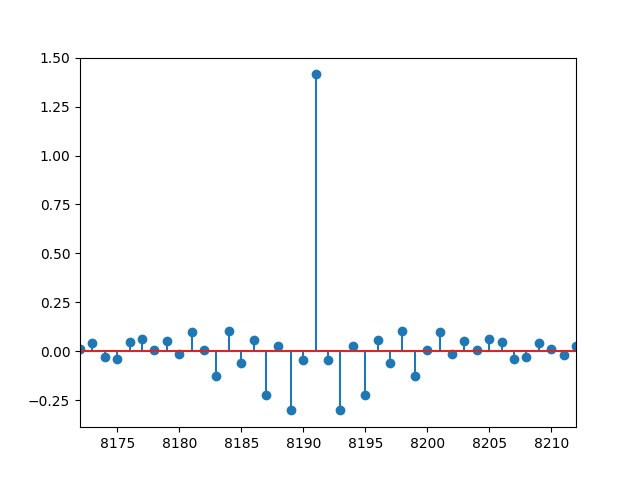

In [ ]:
plt.cla()
plt.close()
plt.figure()
plt.stem(aux)
plt.xlim(len(white_ht[1*fs:3*fs])-20, len(white_ht[1*fs:3*fs])+20)
plt.show()

# FILTRO

C:\Users\sch_b\AppData\Local\Temp\ipykernel_20472\4032356321.py:30: RuntimeWarning: divide by zero encountered in log10
  plt.plot(frequencies, 20 * np.log10(magnitude_response))


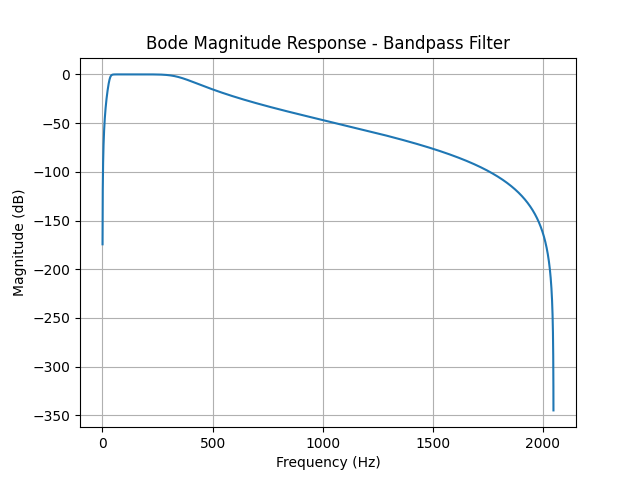

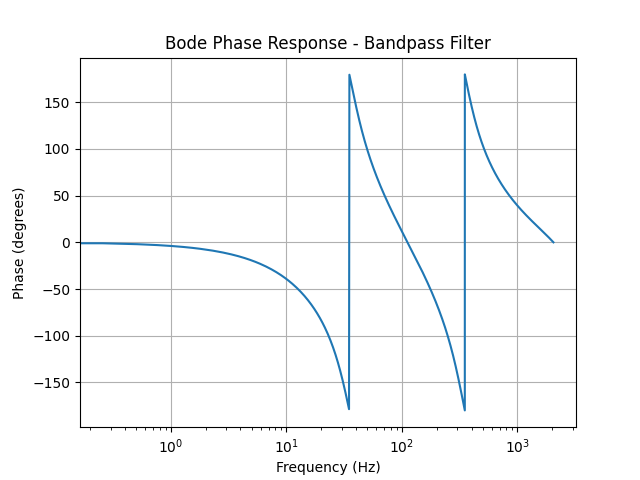

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz, sosfreqz

# Define the sampling frequency and Nyquist frequency
fs = 4096  # Sampling frequency

# Define passband and stopband frequencies in Hz
low_cutoff = 35
high_cutoff = 350

# Convert frequencies to normalized frequencies (Nyquist frequency = 0.5)
nyq = 0.5 * fs
low_cutoff_norm = low_cutoff / nyq
high_cutoff_norm = high_cutoff / nyq

# Design the bandpass filter using second-order sections (SOS)
sos = butter(N=4, Wn=[low_cutoff_norm, high_cutoff_norm], btype='band', output='sos')
b, a = butter(N=6, Wn=[low_cutoff_norm, high_cutoff_norm], btype='band')

# Calculate the frequency response of the filter
frequencies, response = sosfreqz(sos, worN=8000, fs=fs)

# Extract magnitude and phase responses
magnitude_response = np.abs(response)
phase_response = np.angle(response, deg=True)

# Plot Bode magnitude response
plt.figure()
plt.plot(frequencies, 20 * np.log10(magnitude_response))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.title('Bode Magnitude Response - Bandpass Filter')
plt.show()

# Plot Bode phase response
plt.figure()
plt.semilogx(frequencies, phase_response)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (degrees)')
plt.grid(True)
plt.title('Bode Phase Response - Bandpass Filter')
plt.show()


# LEVINGSTON 32 SEC

In [ ]:
import h5py

def dump_info(name, obj):
    #print("{0} :".format(name))
    try:
        #print("   .value: {0}".format(obj[()]))
        for key in obj.attrs.keys():
            pass
            #print("     .attrs[{0}]:  {1}".format(key, obj.attrs[key]))
    except:
        pass

filename = 'L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'
file = h5py.File(filename, 'r')
file.visititems(dump_info)

In [ ]:
dset = file['strain/Strain'][()]
fs = 1 / file['strain/Strain'].attrs['Xspacing']
print(fs)

4096.0


In [ ]:
len(dset)/fs

4096.0

Segundos de L =  5.0
Numero de samples de L =  20480
Resolucion Espectral en Hz 0.4


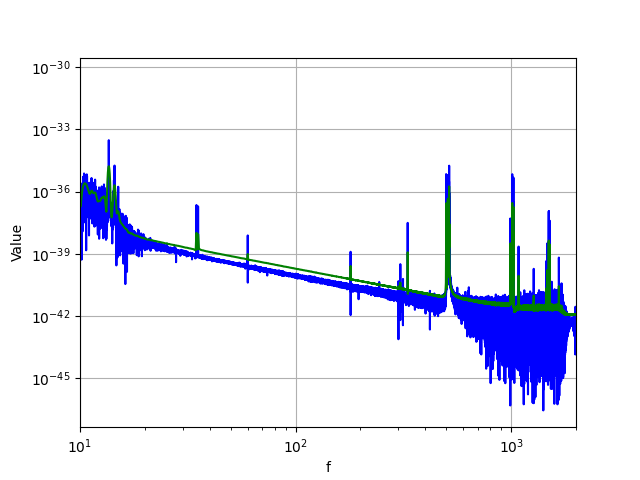

In [ ]:
L_seg = 5
L = int(L_seg*fs)
print('Segundos de L = ', L/fs)
print('Numero de samples de L = ', L)
""" N = int(fs*L_seg*3)
print('Segundos de N = ', N/fs)
print('Size N = ', N) """
print('Resolucion Espectral en Hz', 2/L_seg)

data = dset[0:int(100*fs)]
try:
    Rxx, w = periodogram_smoothing(data, L, len(data))
except CustomException as e:
    print("Custom exception caught:", e)

w = w * fs / (2*np.pi)

Rxx2, w2 = periodogram(dset[0:int(100*fs)], len(dset[0:int(100*fs)]))
w2 = w2*fs/(2*np.pi)

plt.figure()
plt.plot(w2, Rxx2, color = 'b')
plt.plot(w, Rxx, color = 'g')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f')
plt.ylabel('Value')
plt.xlim(10, 2000)
#plt.ylim(-850, -750)
#plt.xlim(0, np.pi)
plt.grid(True)
plt.show()



STD: =  0.019620869289521312


c:\Users\sch_b\OneDrive\Documentos\PASA\.PASA\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\sch_b\OneDrive\Documentos\PASA\.PASA\Lib\site-packages\IPython\lib\display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


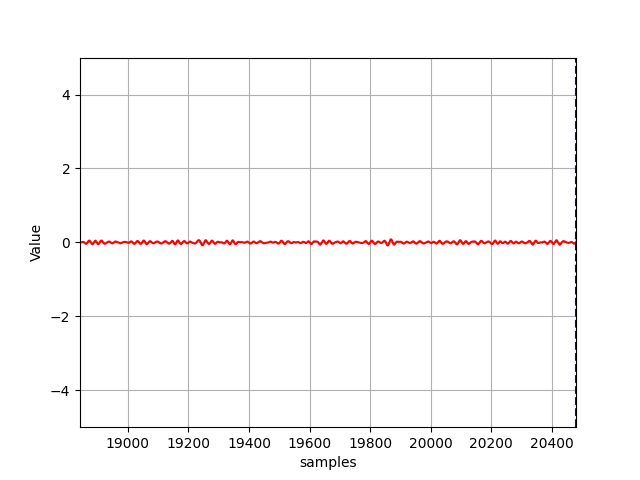

In [ ]:
from IPython.display import Audio

event_time = 1126259462
deltaT = 5
start_time = file['quality/injections/Injmask'].attrs['Xstart']
te = int((event_time-start_time)*fs)
event_samples = dset[te-int(deltaT*fs):te+int(deltaT*fs)] * signal.get_window(window="hann", Nx=len(event_samples), fftbins= False) 
Nt = len(w)-1000#len(event_samples)


freqs = fft.fftshift(fft.fftfreq(Nt, 1))

hf = fft.fftshift(fft.fft(event_samples, n = Nt))
norm = 1./np.sqrt(1./(1*2))
interpoler = inter.interp1d(w/fs, Rxx)
white_hf = hf / np.sqrt(interpoler(freqs)) * norm
white_ht = fft.ifft(fft.ifftshift(white_hf), n=Nt)


""" freqs = fft.rfftfreq(Nt, 1)

hf = fft.rfft(event_samples, n = Nt)
norm = 1./np.sqrt(1./(1*2))

interpoler = inter.interp1d(fft.ifftshift(w)/fs, fft.ifftshift(Rxx))
white_hf = hf / np.sqrt(interpoler(freqs)) * norm
white_ht = fft.ifft(white_hf, n=Nt) """


plt.close()
plt.figure()
plt.cla()

filtered_signal = sosfilt(sos, white_ht)
filtered_signal_phase = signal.filtfilt(b, a, white_ht)

print('STD: = ', np.std(white_ht[60000:64000]))

#plt.plot(white_ht , color = 'r')
time = np.arange(0, len(filtered_signal_phase))/fs
plt.plot(filtered_signal_phase, color = 'r')
#plt.xscale('log')
#plt.yscale('log')
#plt.plot( (event_samples - np.mean(event_samples))/ np.max((event_samples - np.mean(event_samples))), color = 'b' )

Audio((white_ht - np.mean(white_ht))/ np.max((white_ht - np.mean(white_ht))), rate=fs)
#pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)*fs/(2*np.pi)
#pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
#plt.xticks(pi_ticks, pi_labels)
plt.xlabel('samples')
plt.ylabel('Value')
plt.axvline(x=int(len(event_samples)/2), color='b', linestyle='--', label='Vertical Line')
plt.xlim((int(len(event_samples)/2) - int(0.4*fs)), (int(len(event_samples)/2) + int(0*fs)))
#plt.xlim(63000, 63300)
plt.ylim(-5, 5)
#plt.xlim(0, np.pi)
plt.grid(True)
plt.show()